<h1 class="title">Python Tips #7<br>Reproducing Stata's Standard Errors</h1>
<br>
<center>Michael Siebel</center>
<br>

In [1]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

%run ../HTML_Functions.ipynb 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Recreating Stata

Lately, I have been recreating Stata estimates using Python.  Below, I reproduce Stata's (and R's survey package's) robust standard errors it uses in its prop and mean commands.  I am using population data from Python's vega_datasets.

In [2]:
# Core Packages
import numpy as np
import pandas as pd
from vega_datasets import data

# Load data
df = data.population()
df['female'] = df['sex']-1
df = df[['year', 'female', 'age', 'people']]

df.head()

,year,female,age,people
0,1850,0,0,1483789
1,1850,1,0,1450376
2,1850,0,5,1411067
3,1850,1,5,1359668
4,1850,0,10,1260099


# Weighted Standard Error

Statsmodels is a common Python library for producing weighted statistics.  It uses the most conventional method for calculating weighted standard deviations (note: standard error is simply the standard deviation divided by the square root of the sample size).  Unfortunately, this is not how Stata or R calculates weighted standard deviations as they calculate robust corrections.  Below, Python calculates a standard error of 0.021, while Stata calculates 0.028.

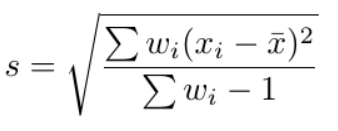

In [3]:
from statsmodels.stats.weightstats import DescrStatsW

stat = DescrStatsW(df['female'], weights=df['people'])
print('% Female')
print('mean:', stat.mean)
print('se:  ', stat.std/np.sqrt(df.shape[0]))

% Female
mean: 0.5046361028351961
se:   0.0209417951337017


**Stata code:**

In [4]:
# . prop female [pw=people]

# Proportion estimation                      Number of obs = 570

# --------------------------------------------------------------
#              |                                   Logit
#              | Proportion   Std. err.     [95% conf. interval]
# -------------+------------------------------------------------
#       female |
#           0  |   .4953639   .0282502      .4401598    .5506813
#           1  |   .5046361   .0282502      .4493187    .5598402
# --------------------------------------------------------------

# Robust Weighted Standard Errors

Fortunately, statsmodels can calculate the same robust weighted standard errors using weighted linear regressions.  

In [5]:
import statsmodels.api as sm

y = df['female']
x = np.ones(df.shape[0])
w = df['people']
fpc = 1

# Calculate
stat = sm.WLS(y, x, weights=w).fit(cov_type='HC1')

# Stats
mean = stat.params[0]
se = stat.bse[0]*fpc

print('% Female')
print('mean:', mean)
print('se:  ', se)

% Female
mean: 0.5046361028351962
se:   0.028250181556609938


# Manual Calculation

So I researched raw code from statsmodels weighted linear regressions so that you don't have to.  Below is how we can calculate it manually.

In [6]:
n = df.shape[0]
y = df['female']
x = df['people']
fpc = 1

# Prop/Mean
mean = (y*x).sum() / (x).sum()

# SE
het_scale = n/(n-1) * ( ((y-mean) * np.sqrt(x))**2 ) # Heteroscedasticity robust covariance matrix (HC1)
wx = np.array([ x*(1/np.sqrt(x)) ]).T # whitened by Cholesky decomposition (cholsigmainv)
pinv_wx = np.linalg.pinv(wx) # Moore-Penrose pseudo-inverse of a matrix
H = np.dot(pinv_wx, het_scale[:, None] * pinv_wx.T).item() # heteroscedasticity-corrected (or “White-Huber”) covariance matrices 
se = np.sqrt(H)*fpc

print('% Female')
print('mean:', mean)
print('se:  ', se)

% Female
mean: 0.5046361028351961
se:   0.028250181556609938


# Custom Function

We can use this code as the basis for rewriting Stata's weighted prop and mean functions.  I wrote stata_func() to allow the y_var to be a binary "0, 1" proportion or a continuous mean--but not multinomial proportions.  The over variable (i.e., subpopution) can be binary, multinomial, or not included.  Weights and FPC can be added, but strata cannot (this would greatly enlarge the function).

In [7]:
# Recreate Stata stats 
def stata_func(y_var, df, over=None, weight=None, fpc=1):
    # Libraries
    import numpy as np
    import pandas as pd
    from category_encoders.one_hot import OneHotEncoder
    
    # Remove weight if weight==None
    if weight is None:
        df['weight'] = np.ones(df.shape[0])
        weight = 'weight'
    # Remove over if over==None
    if over is None:
        df['over'] = np.ones(df.shape[0])
        over = 'over'
    # Prepare over variable to loop
    one_hot = OneHotEncoder(handle_missing='return_nan', use_cat_names=True).fit_transform(df[over].astype('O'))
    x_vars = sorted(one_hot.columns)
    df = pd.concat([df, one_hot], axis=1)
    
    # Calculate Stats
    stats = {}
    stats['stats'] = ('mean', 'se', 'n')
    for x_var in x_vars:
        
        # Text output
        if over == 'over':
            list_name = y_var
        else:
            list_name = y_var + " when " + x_var
        
        # Params
        cw = df[[y_var, x_var, weight]].dropna()
        n = cw.shape[0]
        subpop = cw[cw[x_var]==1]
        y = subpop[y_var]
        x = subpop[weight]
        
        # Prop/Mean
        mean = (y*x).sum() / (x).sum()
        
        # SE
        ## Without weights
        if len(np.unique(x)) == 1:
            het_scale = (y-mean)**2  # Heteroscedasticity robust covariance matrix (HC0)
        ## With weights
        else:    
            het_scale = n/(n-1) * ( ((y-mean) * np.sqrt(x))**2 ) # Heteroscedasticity robust covariance matrix (HC1)
        ## Some linear algebra on the robust covariance matrix    
        wx = np.array([ x*(1/np.sqrt(x)) ]).T # whitened by Cholesky decomposition (cholsigmainv)
        pinv_wx = np.linalg.pinv(wx) # Moore-Penrose pseudo-inverse of a matrix
        H = np.dot(pinv_wx, het_scale[:, None] * pinv_wx.T).item() # heteroscedasticity-corrected (or “White-Huber”) covariance matrices 
        se = np.sqrt(H)*fpc
        
        stats[list_name] = (mean, se, str(n))
        
    stats = pd.DataFrame(stats)
    
    return(stats)

In [8]:
# Adding subpopulations
cats = [-np.inf, 1900, 1950, 1990, np.inf]
cat_labs = ["1850-1900", "1901-1950", "1951-1990", "1991-2000"] 
df['period'] = pd.cut(df['year'], bins=cats, labels=cat_labs)

stata_func('female', df, over='period', weight='people')

,stats,female when period_1850-1900,female when period_1901-1950,female when period_1951-1990,female when period_1991-2000
0,mean,0.490737,0.495204,0.51291,0.510116
1,se,0.051863,0.043864,0.046508,0.089621
2,n,570,570,570,570


In [9]:
stata_func('age', df, over='period', weight='people')

,stats,age when period_1850-1900,age when period_1901-1950,age when period_1951-1990,age when period_1991-2000
0,mean,22.407398,27.478309,30.991718,33.844317
1,se,1.633592,1.577995,1.854626,3.506542
2,n,570,570,570,570


In [10]:
stata_func('age', df, over=['period', 'female'], weight='people')

,stats,age when female_0.0,age when female_1.0,age when period_1850-1900,age when period_1901-1950,age when period_1951-1990,age when period_1991-2000
0,mean,28.665306,30.092819,22.407398,27.478309,30.991718,33.844317
1,se,1.504459,1.565118,1.633592,1.577995,1.854626,3.506542
2,n,570,570,570,570,570,570


# Conclusion

**Why are the standard errors different?**

Let's start by discussing standard deviations.  Traditional standard deviations are calculated by taking overall variance (the sum of values minus the mean squared) relative to the sample size (dividing the sample size and then taking the square root).  The simplest way to add weights is by multiplying the values minus mean by the weights and replacing the sample size with the summation of the weights.  

However, traditional standard deviations only consider total variance relative to the n-value (sample size or summation of weights) and not the distribution of the variance.  Robust standard deviations consider the distribution of the variance.  Mathematically, robust formulas do not sum the variance before relating it to the n-value.  Instead, it considers the variance of each value to the n-value, adds penalties for larger variance distributions, and uses some fancy linear algebra to convert into a single standard deviation value.  

**What does this do (in plain English)?**

Robust standard deviations should always increase the standard deviation from the traditional formula.  Let's call this a "robust correction".  The robust correction should be larger if the difference between each value and the mean is very inconsistent (sometimes large, sometimes small).  If the difference between each value and the mean is often the same, the robust correction shouldn't increase the standard deviation by much.  This is the same in concept to heteroskedasticity in linear regressions.  The formula for robust standard deviations can be found here:

*MacKinnon, J. G., & White, H. (1985). Some heteroskedasticity-consistent covariance matrix estimators with improved finite sample properties. Journal of econometrics, 29(3), 305-325.*

**But aren't we concerned with errors not deviations?**

Standard errors are just scaled standard deviations (scaled to the original values).  We can get the standard error by dividing the standard deviation by the square root of the n-value.  This is true of traditional standard errors and robust standard errors.

# Save Log

In [11]:
from IPython.display import display, Javascript

display(Javascript(
    "document.body.dispatchEvent("
    "new KeyboardEvent('keydown', {key:'s', keyCode: 83, ctrlKey: true}"
    "))"
))

!jupyter nbconvert --to html_toc "Tip7_Reproducing_Stata_SE.ipynb" --ExtractOutputPreprocessor.enabled=False --CSSHTMLHeaderPreprocessor.style=stata-dark 

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook Tip7_Reproducing_Stata_SE.ipynb to html_toc
[NbConvertApp] Writing 416431 bytes to Tip7_Reproducing_Stata_SE.html
